In [55]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('ggplot')
import numpy as np
import h5py


In [60]:
def plot_input_data(x, y, ID, fs=100.0, savefig=False):
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.rc('xtick.major', size=8)
    plt.rc('ytick.major', size=8)
    plt.rc('xtick.minor', size=4)
    plt.rc('ytick.minor', size=4)
    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(6, 5))
    plt.subplots_adjust(left=0.12, bottom=0.12, right=0.98, top=.98,hspace = .1, wspace=.05)
    npts = len(y)
    t = np.linspace(0, npts/fs, npts)
    cpns = ['E', 'N', 'Z']
    for i in range(0,len(axs)-1):
        axs[i].plot(t,x[:,i]/max(abs(x[:,i])),'k', label=cpns[i])
        axs[i].set_ylabel("Amplitude", fontsize=14)
        axs[i].yaxis.set_major_locator(MultipleLocator(1.0))
        axs[i].yaxis.set_minor_locator(MultipleLocator(0.5))
        axs[i].set_ylim(-1.1,1.1)
        axs[i].legend(loc='upper right')
        ##axs[i].tick_params(bottom=False)
        ##axs[i].tick_params(labelbottom=False)
        ##axs[i].spines['bottom'].set_visible(False)
    axs[-1].plot(t,y[:,0],'r',label='Detection')
    axs[-1].set_xlim(0,60)
    axs[-1].set_ylim(-0.05, 1.05)
    axs[-1].legend()
    axs[-1].yaxis.set_major_locator(MultipleLocator(1.0))
    axs[-1].yaxis.set_minor_locator(MultipleLocator(0.5))
    axs[-1].xaxis.set_minor_locator(MultipleLocator(2))
    axs[-1].set_ylabel("Probability", fontsize=14)
    axs[-1].set_xlabel("Time (s)", fontsize=14)
    if savefig == True:
        fig.savefig(ID+'.png', dpi = 100)
    plt.show()
    
def _normalize(data, mode = 'max'):  
    'Normalize waveforms in each batch'
    data -= np.mean(data, axis=0, keepdims=True)
    if mode == 'max':
        max_data = np.max(data, axis=0, keepdims=True)
        assert(max_data.shape[-1] == data.shape[-1])
        max_data[max_data == 0] = 1
        data /= max_data              

    elif mode == 'std':               
        std_data = np.std(data, axis=0, keepdims=True)
        assert(std_data.shape[-1] == data.shape[-1])
        std_data[std_data == 0] = 1
        data /= std_data
    return data

def data_generation_volc(file_name, list_IDs_temp):
    batch_size = len(list_IDs_temp)
    dim = 6000
    n_channels = 3
    augmentation = False
    shift_event_r = None
    norm_mode = 'std'
    label_type = 'triangle'
    coda_ratio = 0.4
    # ==========================================================
    X = np.zeros((batch_size, dim, n_channels))
    y1 = np.zeros((batch_size, dim, 1))
    fl = h5py.File(file_name, 'r')
    for i, ID in enumerate(list_IDs_temp):
        additions = None
        dataset = fl.get('data/'+str(ID))
        if ID.split('_')[-1] == 'EV': #######
            data = np.array(dataset)
            spt = int(dataset.attrs['p_arrival_sample']);
            sst = int(dataset.attrs['s_arrival_sample']);
            coda_end = int(dataset.attrs['coda_end_sample']);
            snr = dataset.attrs['snr_db'];
            y1[i, spt:coda_end, 0] = 1
        #elif ID.split('_')[-1] == 'NO':
        elif ID.split('_')[-1] == 'NO':
            data = np.array(dataset)
        elif ID.split('_')[-1] == 'VO':
            data = np.array(dataset)
            spt = int(dataset.attrs['p_arrival_sample']);
            coda_end = int(dataset.attrs['coda_end_sample']);
            y1[i, spt:coda_end, 0] = 1
        elif ID.split('_')[-1] == 'VC':
            data = np.array(dataset)
            spt = dataset.attrs['p_arrival_sample']
            coda_end = dataset.attrs['coda_end_sample']
            #print('p_arrival_sample', type(spt))
            #print(spt)
            #print('coda_end_sample', type(coda_end))
            #print(coda_end)
            pts = [list(pair) for pair in zip(spt, coda_end)]
            for point in pts:
                xxi,yyi=(point)
                y1[i, xxi:yyi+1, 0] = 1
        print(dataset.attrs['trace_category'],'-------->')
        ## ==================================================================== Augmentation 
        if augmentation == True:
            print('Funcion no definida')
            pass
        elif augmentation == False:  
            #if shift_event_r and dataset.attrs['trace_category'] == 'earthquake_local':
            #    data, spt, sst, coda_end = _shift_event(data, spt, sst, coda_end, snr, shift_event_r/2);                     
            if norm_mode:                    
                data = _normalize(data, norm_mode)                          
        X[i, :, :] = data
        ## ==================================================================== Labeling
        #if dataset.attrs['trace_category'] == 'earthquake_local': 
        #    y1[i, spt:coda_end, 0] = 1
    fl.close() 
    return X, y1.astype('float32')

In [61]:
# # ==================================================== Run 1
args = {
"input_hdf5": './VSED_dataset/data_VSED_PF_filt_1_25.hdf5',
"input_csv":  './VSED_dataset/data_VSED_PF_filt_1_25.csv',
}

In [62]:
import pandas as pd
df = pd.read_csv(args['input_csv'])
print("Total num:",len(df))
df.head(5)

Total num: 6905


,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
0,PF,BOR,EH,-21.246882,55.706053,2540,NaN,auto_v1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-06-03 17:42:24.013130,noise_volcano,BOR.PF_20140603174224_NO
1,PF,BOR,EH,-21.246882,55.706053,2540,NaN,auto_v1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-06-04 04:12:18.163129,noise_volcano,BOR.PF_20140604041218_NO
2,PF,BOR,EH,-21.246882,55.706053,2540,[3866],manual,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,[5507],2014-06-06 15:38:00.283131,earthquake_volcano_VT1,BOR.PF_20140606153800_VC
3,PF,BOR,EH,-21.246882,55.706053,2540,NaN,auto_v1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-06-07 20:29:03.693130,noise_volcano,BOR.PF_20140607202903_NO
4,PF,BOR,EH,-21.246882,55.706053,2540,NaN,auto_v1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-06-08 08:11:47.163130,noise_volcano,BOR.PF_20140608081147_NO


noise_volcano -------->


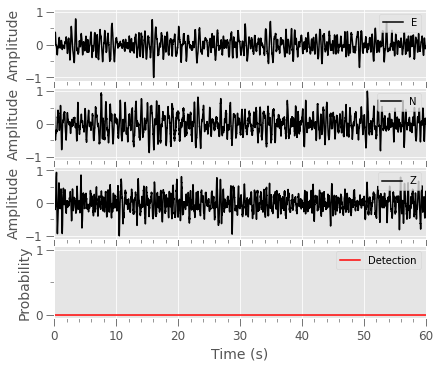

earthquake_volcano_VT1 -------->


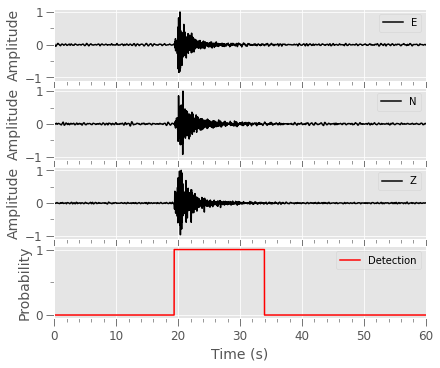

earthquake_volcano_VT1-VT1 -------->


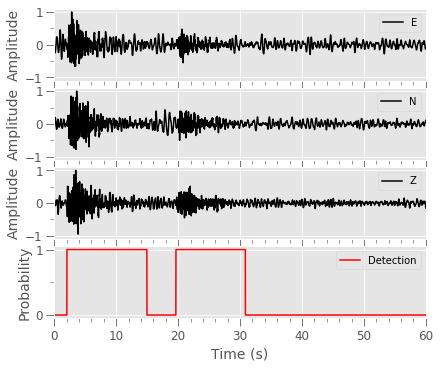

earthquake_volcano_None -------->


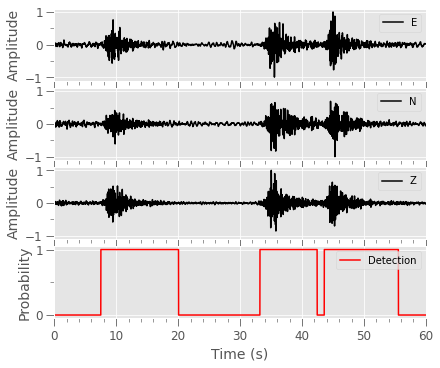

earthquake_volcano_LP1 -------->


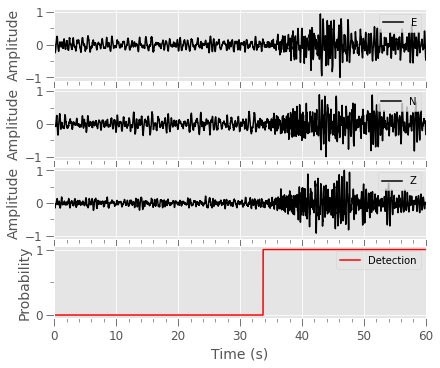

earthquake_volcano_RFL -------->


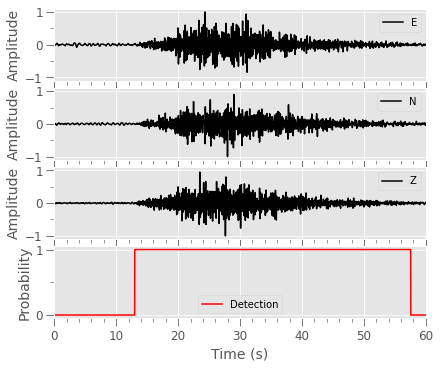

earthquake_volcano_RFL -------->


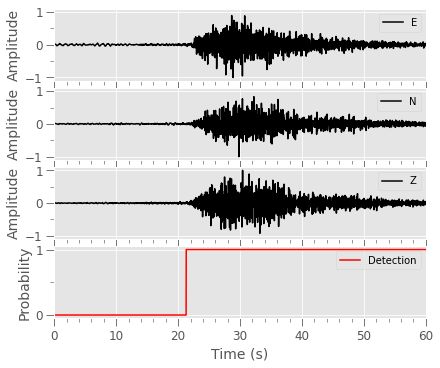

earthquake_volcano_TRE -------->


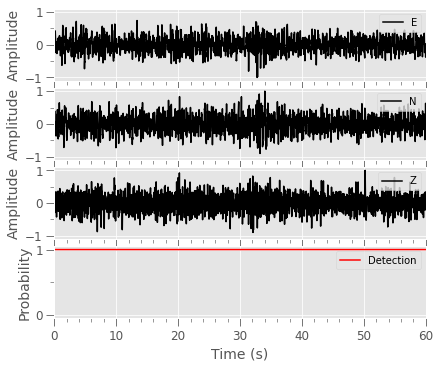

In [66]:
ixs = [5, 54, 987, 5216, 5192, 5438, 4790, 1961]
for ix in ixs:
    ID_curr = df.trace_name[ix]
    xx, yy = data_generation_volc(args['input_hdf5'], [ID_curr])
    # ====================================================================== Plot loop
    for i in range(len(xx)):
        plot_input_data(xx[i],yy[i],ID_curr)#,savefig=True)